## 实战Kaggle比赛：图像分类（CiFar-10）
比赛网址：https://www.kaggle.com/c/cifar-10/data

In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [2]:
#! mkdir /media/snnu/ac92881d-6569-4252-9c63-249f85dd3259/ckq-dataSet/cifar-10


In [3]:
#! unzip /media/snnu/ac92881d-6569-4252-9c63-249f85dd3259/ckq-dataSet/cifar-10.zip  -d /media/snnu/ac92881d-6569-4252-9c63-249f85dd3259/ckq-dataSet/cifar-10

In [4]:
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

demo = False

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '/media/snnu/ac92881d-6569-4252-9c63-249f85dd3259/ckq-dataSet/cifar-10'

整理数据，将label读进来

In [5]:
def read_csv_labels(fname):
    """读取 fname 来给标签字典返回一个文件名"""
    with open(fname , 'r') as f:
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name ,label) for name ,label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))

将验证集从原始的训练集中拆分从来

In [6]:
def copyfile(filename ,target_dir):
    """将文件复制到目标目录"""
    os.makedirs(target_dir,exist_ok=True)
    shutil.copy(filename,target_dir)

### 当前采用最简单的分类的数据格式
    -cifar10
     -train
      -类别1
       -图片
      -类别2
      -类别3

In [7]:
def reorg_train_valid(data_dir,labels,valid_ratio):
    """将验证集从原始的训练集中拆分出来"""
    #训练数据集中样本最少的类别中的样本数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    #验证集中每个类别样本数
    n_valid_per_label = max(1,math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir,'train')):      #整理训练集数据
        label  = labels[train_file.split('.')[0]]     #取到图片名，去掉jpg后缀，用来取对应的类别
        fname  = os.path.join(data_dir,'train' , train_file)  #获取到当前图片的路径
        copyfile(fname ,os.path.join(data_dir,'train_valid_test','train_valid',label)) #挪动文件
        
        if label not in label_count or label_count[label] <n_valid_per_label:
            copyfile(fname,os.path.join(data_dir,'train_valid_test',
                                        'valid',label))
            label_count[label] = label_count.get(label,0)+1
        else:
            copyfile(fname,os.path.join(data_dir,'train_valid_test',
                                           'train',label))
    return n_valid_per_label

#### 说明
    --train 和 valid数据集都是从训练数据集来的。train_valid是cifar10原始的train文件；这里没有做5则交叉验证
    在train上面训练模型，在valid上调结果参数；选定参数之后，在完整的数据集上再训练一边

In [8]:
def reorg_test(data_dir):
    """将测试数据整理到测试文件夹下，方便后续使用"""
    for test_file in os.listdir(os.path.join(data_dir,'test')):
        copyfile(os.path.join(data_dir,'test',test_file),os.path.join(data_dir,'train_valid_test','test','unknown'))
        

调用前面定义函数，整理文件夹

In [9]:
# ! mkdir /media/snnu/ac92881d-6569-4252-9c63-249f85dd3259/ckq-dataSet/cifar-10/train
# ! mkdir /media/snnu/ac92881d-6569-4252-9c63-249f85dd3259/ckq-dataSet/cifar-10/test

In [10]:
# sudo apt-get install p7zip-full
# ! 7z x /media/snnu/ac92881d-6569-4252-9c63-249f85dd3259/ckq-dataSet/cifar-10/train.7z -r -o./media/snnu/ac92881d-6569-4252-9c63-249f85dd3259/ckq-dataSet/cifar-10/train 
# ! 7z x /media/snnu/ac92881d-6569-4252-9c63-249f85dd3259/ckq-dataSet/cifar-10/test.7z -r -o./media/snnu/ac92881d-6569-4252-9c63-249f85dd3259/ckq-dataSet/cifar-10/test
#建议在终端操作解压，避免笔记本卡死

In [11]:
def reorg_cifar10_data(data_dir,valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir,'trainLabels.csv'))
    reorg_train_valid(data_dir,labels,valid_ratio)
    reorg_test(data_dir)

#batch_size = 32 if demo else 128
batch_size = 32 if demo else 256
valid_ratio = 0.1
#reorg_cifar10_data(data_dir,valid_ratio)

图像增广

In [12]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),                        #做出能裁剪的空间，然后做剪裁
    torchvision.transforms.RandomResizedCrop(32,scale=(0.64,1.0),ratio=(1.0,1.0)),  #最小的面积有64%，也就是高宽至少有80%在
    torchvision.transforms.RandomHorizontalFlip(),                #水平翻转
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])
    
])
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])
    
])

读取图片数据集

In [13]:
train_ds,train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir,'train_valid_test',folder),
    transform = transform_train) for folder in ['train','train_valid']]
valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir,'train_valid_test',folder),transform=transform_test) for folder in ['valid','test']]

指定上面定义的所有图像增广操作

In [14]:
train_iter , train_valid_iter = [
    torch.utils.data.DataLoader(
        #droplast 是说最后一batch不满足32或128，就丢了
        dataset,batch_size,shuffle=True,drop_last =True 
    )
    for dataset in (train_ds,train_valid_ds)
]
valid_iter = torch.utils.data.DataLoader(
    valid_ds, batch_size,shuffle =False,drop_last =True
)
test_iter = torch.utils.data.DataLoader(
    test_ds,batch_size,shuffle =False,drop_last=True
)

模型

In [15]:
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes ,3) #3代表三通道
    return net

loss = nn.CrossEntropyLoss(reduction = 'none') #不要加起来

In [18]:
def train(net ,train_iter,valid_iter,num_epochs,lr,wd,devices,lr_period,lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr =lr ,momentum=0.9,weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer,lr_period,lr_decay)
    num_batches,timer = len(train_iter),d2l.Timer()
    legend = ['train loss' , 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],
                           legend=legend)
    net = nn.DataParallel(net,device_ids=devices).to(devices[0])
    for epoch in range (num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i ,(features,labels) in enumerate(train_iter):
            timer.start()
            l,acc = d2l.train_batch_ch13(net,features,labels,loss,trainer,devices)
            metric.add(l,acc,labels.shape[0])
            timer.stop()
            if (i+1)%(num_batches//5) == 0 or i == num_batches -1:
                animator.add(epoch+(i+1)/num_batches,
                            (metric[0] / metric[2],metric[1] /metric[2],
                            None))
            if valid_iter is not None:
                valid_acc = d2l.evaluate_accuracy_gpu(net,valid_iter)
                animator.add(epoch+1,(None,None,valid_acc))
            scheduler.step()
        measurse = (f'train loss {metric[0] / metric[2]:.3f},'
                   f'train acc {metric[1] / metric[2]:.3f}')
        if valid_iter is not None:
            measurse +=f', valid acc {valid_acc:.3f}'
        print(measurse+ f'\n{metric[2] * num_epochs / timer.sum():.1f}'
             f' examples/sec on {str(devices)}')

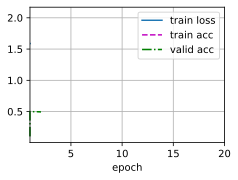

In [ ]:
devices ,num_epochs ,lr ,wd = [0],20,2e-4,5e-4
lr_period,lr_decay,net = 4,0.9,get_net()
train(net,train_iter,valid_iter,num_epochs,lr,wd,devices,lr_period,lr_decay)